# Product Demand Forecasting & Segmentation Using Time Series, Clustering, and XGBoost

### Overview
This project builds an end-to-end **weekly product-level demand forecasting model** using historical sales and pricing data. The analysis combines **time series feature engineering**, **unsupervised product segmentation (K-Means Clustering)**, and a **gradient-boosted regression model (XGBoost)** to forecast demand and evaluate performance across distinct product demand regimes.

This project aims to:
- Forecast weekly product demand
- Segment products into interpretable behavioral clusters
- Evaluate forecast performance by cluster
- Translate modeling results into insights

In [2]:
# Importing libaries we will be using
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

The data used in this project was apart of the University of Nicosia - Featured Prediction Competition which can be found here on Kaggle.com: https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview. 

These datasets contain Walmart product-level data, including pricing, day-of-week indicators, holidays, and demand observations from three states (CA, TX, and WI).

The sales dataset includes data on the prodcts that were sold at each of the store locations within this dataset and the quanity sold at a daily level. 

The calendar dataset includes all the dates (month, year, weekday) within the dataset and information including whether that specific day is a holiday as well.

The price dataset list the specific price for a product at each store location.

In [51]:
# loading in the three datasets
sales = pd.read_csv('sales_train_validation.csv')
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


The sales dataset was originally in wide formating so I converted it to long format so that in-depth data manipulation, statistical modeling, and any plotting can accurately be performed.

The original dataset had the date variable in the wide format with its value being the quanity sold of each product that date. I have unpivoted the data column.

In [52]:
id_cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]

sales_long = sales.melt(
    id_vars=id_cols,
    var_name="d", # d (day count) to match the naming convention on the calender dataset
    value_name="demand" 
)

sales_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [6]:
sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 8 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   id        object
 1   item_id   object
 2   dept_id   object
 3   cat_id    object
 4   store_id  object
 5   state_id  object
 6   d         object
 7   demand    int64 
dtypes: int64(1), object(7)
memory usage: 3.5+ GB


The Sales dataset used d_1 through d_1914 to denote dates instead of the actual dates. The code below merges the sales dataset with the calender dataset to pair the dates to a more interperable form.

In [53]:
calendar_subset = calendar[["d", "date", "wm_yr_wk"]] # extracting specific date columns from the calender dataset
calendar_subset["date"] = pd.to_datetime(calendar_subset["date"]) # converting date variable to the python datatime data type

sales_long = sales_long.merge(calendar_subset, on="d", how="left")

/var/folders/74/_19dm8xn5ys5fmywmrbsqcb80000gn/T/ipykernel_92780/318543327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_subset["date"] = pd.to_datetime(calendar_subset["date"]) # converting date variable to the python datatime data type


The time-series features and forecast model will be based on weekly time intervals. Below creates a new dataframe titled "weekly sales" that includes the products weekly quanity sold (demand). 

This weekly_sales dataframe will then be used to create time-series specific features and to train the model.

The benefit of this weekly aggegragation is to reduce noise, solve for zero sales days, and decreases runtimes (3.5GB vs 25.5MB memory usage).

In [54]:
weekly_sales = (
    sales_long
    .groupby(["item_id", "wm_yr_wk", "store_id"])
    .agg(
        weekly_demand=("demand", "sum"),
        week_start=("date", "min")
    )
    .reset_index()
    .sort_values(["item_id", "wm_yr_wk"])
)

In [9]:
weekly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   item_id        object        
 1   wm_yr_wk       int64         
 2   store_id       object        
 3   weekly_demand  int64         
 4   week_start     datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 318.7+ MB


Now that the daily sales have been aggregated to a weekly level, I am able to join the weekly_sales dataframe I created with the prices dataset which has product prices at a weekly and store level.

In [55]:
# join on item_id + store_id + wm_yr_wk 
weekly_sales = weekly_sales.merge(prices, on=["item_id", "wm_yr_wk", "store_id"], how="left")

In [56]:
weekly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   item_id        object        
 1   wm_yr_wk       int64         
 2   store_id       object        
 3   weekly_demand  int64         
 4   week_start     datetime64[ns]
 5   sell_price     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 382.4+ MB


### Time-Series Feature Engineering

Extracting different features our model allows us to fully take advantage of our time-series data. 

For our model specifically, I created lag features and rolling window features to help uncover any trends within the data.

As it is not clear what the appropriate amount of lags to include, we have started off with 1, 2, and 4. This can be further evaluated and adjusted. The rolling window feature aids in this as it will help smooth out short-term fluctuations and highlight longer-term trends or patterns.

In [59]:
# Lag feature for weekly demand

for lag in [1, 2, 4]:
    weekly_sales[f"lag_{lag}_demand"] = (
        weekly_sales
        .groupby("item_id")["weekly_demand"]
        .shift(lag)
    )
    
# Lag feature for weekly price
weekly_sales[f"lag_1_price"] = (
    weekly_sales
    .groupby("item_id")["sell_price"]
    .shift(1)
    )


In [58]:
# Rolling Window Feature by mean and standard deviation for demand and price

weekly_sales["rolling_demand_mean_4"] = (
    weekly_sales
    .sort_values(by=["item_id", "wm_yr_wk"])
    .groupby("item_id")["weekly_demand"]
    .shift(1)
    .rolling(window = 4, min_periods=1)
    .mean()
)

weekly_sales["rolling_demand_std_4"] = (
    weekly_sales
    .sort_values(by=["item_id", "wm_yr_wk"])
    .groupby("item_id")["weekly_demand"]
    .shift(1)
    .rolling(window = 4, min_periods=1)
    .std()
)


# Price

weekly_sales["rolling_price_mean_4"] = (
    weekly_sales
    .sort_values(by=["item_id", "wm_yr_wk"])
    .groupby("item_id")["sell_price"]
    .shift(1)
    .rolling(window = 4, min_periods=1)
    .mean()
)

In [14]:
'''
weekly_sales["trend_demand"] = (
    weekly_sales["weekly_demand"] -
    weekly_sales["rolling_price_mean_4"]
)
'''

'\nweekly_sales["trend_demand"] = (\n    weekly_sales["weekly_demand"] -\n    weekly_sales["rolling_price_mean_4"]\n)\n'

In [60]:
weekly_sales.head()

,item_id,wm_yr_wk,store_id,weekly_demand,week_start,sell_price,lag_1_demand,lag_2_demand,lag_4_demand,lag_1_price,rolling_demand_mean_4,rolling_demand_std_4,rolling_price_mean_4
0,FOODS_1_001,11101,CA_1,10,2011-01-29,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FOODS_1_001,11101,CA_2,11,2011-01-29,2.0,10.0,NaN,NaN,2.0,10.000000,NaN,2.0
2,FOODS_1_001,11101,CA_3,8,2011-01-29,2.0,11.0,10.0,NaN,2.0,10.500000,0.707107,2.0
3,FOODS_1_001,11101,CA_4,5,2011-01-29,2.0,8.0,11.0,NaN,2.0,9.666667,1.527525,2.0
4,FOODS_1_001,11101,TX_1,2,2011-01-29,2.0,5.0,8.0,10.0,2.0,8.500000,2.645751,2.0


### Features for Clustering (Product SKU-level Segmentation)

As apart of our product-based k-means clustering that will be used as a feature for the model, I created additional features that will aid in creating the clusters. 

In [61]:
product_features = (
    weekly_sales
    .groupby("item_id")
    .agg(
        mean_demand=("weekly_demand", "mean"),
        std_demand=("weekly_demand", "std"),
        zero_demand_pct=("weekly_demand", lambda x: (x == 0).mean()),
        max_demand=("weekly_demand", "max"),
        mean_price=("sell_price", "mean"),
        std_price=("sell_price", "std"),
        max_price=("sell_price", "max"),
        min_price=("sell_price", "min")
    )
    .reset_index()
)

product_features.head()

,item_id,mean_demand,std_demand,zero_demand_pct,max_demand,mean_price,std_price,max_price,min_price
0,FOODS_1_001,4.469708,4.430407,0.166788,33,2.164480,0.117222,2.24,0.99
1,FOODS_1_002,2.676642,2.450198,0.203285,14,8.917963,0.483543,9.48,7.66
2,FOODS_1_003,4.888321,4.716103,0.136861,27,2.967745,0.152056,3.23,2.50
3,FOODS_1_004,47.255839,49.596958,0.277372,313,1.844525,0.106369,1.96,1.50
4,FOODS_1_005,8.362774,10.396369,0.275547,97,3.323215,0.195676,3.54,0.10


These two additonal features include:
 - The standard deviation of price divided by the mean price to track how volatile pricing is. 
 - Max_discount_pct calculates the biggest price change a product has had due to discounts.

In [62]:
product_features["price_cv"] = (
    product_features["std_price"] / product_features["mean_price"]
)

product_features["max_discount_pct"] = (
    (product_features["max_price"] - product_features["min_price"]) /
    product_features["max_price"]
)

To ensure that these product features are of the same weight while creating the clusters, I scalled them by using MinMaxScaler() from the scikit-learn libary. 

In [63]:
scaler = MinMaxScaler()

scaled_features = scaler.fit_transform(
    product_features[['mean_demand', 'std_demand', 'zero_demand_pct', 'max_demand', 'mean_price', 'std_price', 'max_price', 'min_price', 'price_cv', 'max_discount_pct']]
)

product_features_scaled = pd.DataFrame(
    scaled_features,
    columns=['mean_demand_scaled', 'std_demand_scaled', 'zero_demand_scaled', 'max_demand_scaled', 'mean_price_scaled', 'std_price_scaled', 'max_price_scaled', 'min_price_scaled', 'price_cv_scaled', 'max_discount_pct_scaled']
)

In [19]:
product_features_scaled.head()

,mean_demand_scaled,std_demand_scaled,zero_demand_scaled,max_demand_scaled,mean_price_scaled,std_price_scaled,max_price_scaled,min_price_scaled,price_cv_scaled,max_discount_pct_scaled
0,0.011656,0.010552,0.179075,0.008204,0.066058,0.024150,0.018769,0.036337,0.092318,0.558628
1,0.006753,0.005220,0.218260,0.002829,0.293117,0.099619,0.086376,0.283648,0.092427,0.192187
2,0.012801,0.011321,0.146944,0.006506,0.093064,0.031326,0.028014,0.092325,0.087339,0.226246
3,0.128661,0.132170,0.297806,0.087412,0.055301,0.021914,0.016155,0.055247,0.098301,0.234943
4,0.022302,0.026616,0.295846,0.026308,0.105016,0.040313,0.030909,0.003337,0.100371,0.972783


### Creating the Clusters

Before initializing k-means clusters, I had to decide on a good number of clusters to prevent under or overfitting the data points.

In order to do this, I used two metrics to assist which are the Silhouette Score and the Within Cluster Sum of Squares (WCSS) which are both then plotted. 

As we can see, both metrics show that 5 is a solid choice for the number of clusters we should use.

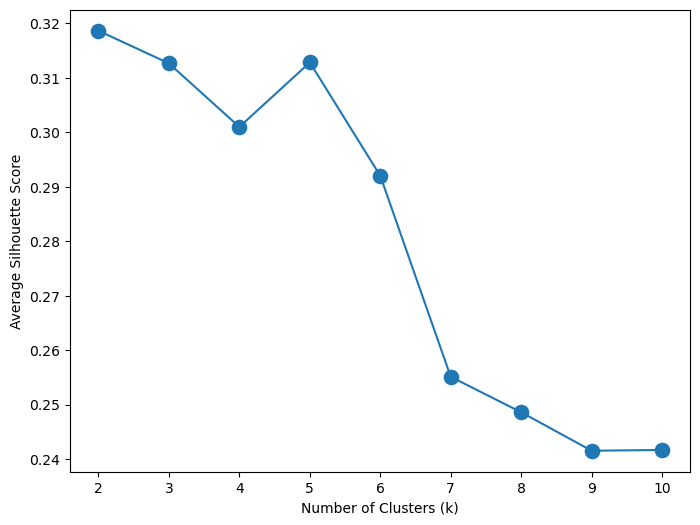

In [20]:
# Average Silhouette Score
from sklearn.metrics import silhouette_score

silhouette = []
for k in range(2, 11):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(product_features_scaled)
    silhouette.append(silhouette_score(product_features_scaled, km.labels_))

silhouette_series = pd.Series(silhouette, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = silhouette_series, x = silhouette_series.index)
ax = sns.scatterplot(y = silhouette_series, x = silhouette_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Average Silhouette Score')

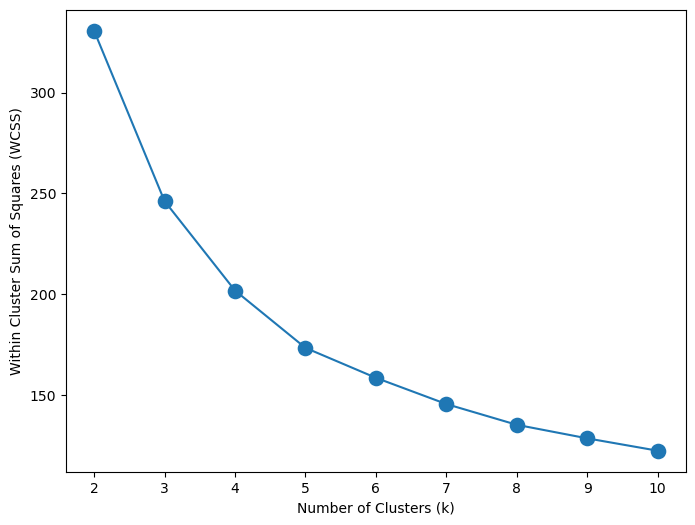

In [21]:
# The Within Cluster Sum of Squares (WCSS)
wcss = []
for k in range(2, 11):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(product_features_scaled)
    wcss.append(km.inertia_)

wcss_series = pd.Series(wcss, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = wcss_series, x = wcss_series.index)
ax = sns.scatterplot(y = wcss_series, x = wcss_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Within Cluster Sum of Squares (WCSS)')

Now I fitted the K-means model with 5 clusters to the scaled product features and visualize how these clusters look.

In [64]:
km = KMeans(n_clusters = 5, n_init = 25, random_state = 0)

km.fit(product_features_scaled) # cluster the data

KMeans(n_clusters=5, n_init=25, random_state=0)

At first glance, between the 5 clusters 0,1,2, and 4 have a similar distribution of products while cluster 3 has less suggesting these products may be less in quantity or more premium.

In [65]:
pd.Series(km.labels_).value_counts().sort_index()

0    751
1    618
2    666
3    187
4    827
Name: count, dtype: int64

In [66]:
centroids = scaler.inverse_transform(km.cluster_centers_)

cluster_centers = pd.DataFrame(
    centroids,
    columns=['mean_demand', 'std_demand', 'zero_demand_pct', 'max_demand', 'mean_price', 'std_price', 'max_price', 'min_price', 'price_cv', 'max_discount_pct']
)

All the products and each clusters centroid is plotted below. 

The X and Y axis of the plot is mean demand vs volatility:
- X-axis: Mean Weekly Demand - How much the product sells on average

- Y-axis: Demand Volatility (Std Dev) - How unpredictable demand is week-to-week

Each clusters group contains products with similar demand behavior.

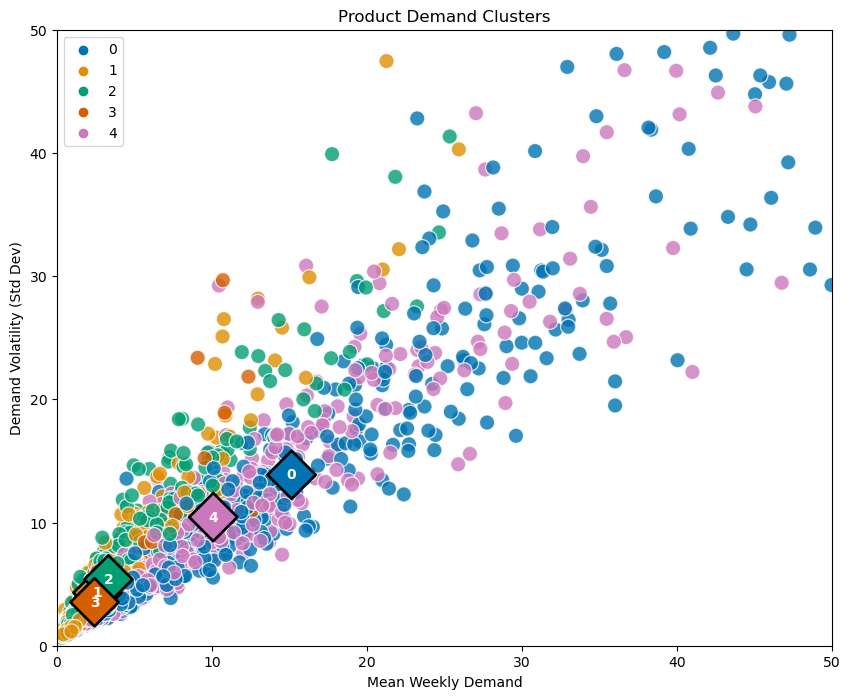

In [67]:
# Set the figure size
plt.figure(figsize=(10, 8))

#Plot the Clusters
ax = sns.scatterplot(
    data=product_features,
    x='mean_demand',
    y='std_demand',
    hue=km.labels_,
    palette='colorblind',
    alpha=0.8,
    s=120
)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers, 
                     x='mean_demand',
                     y='std_demand', 
                     hue = cluster_centers.index, 
                     palette = 'colorblind', 
                     s = 600,
                     marker = 'D',
                     ec = 'black', 
                     legend = False)


for i in range(len(cluster_centers)):
    plt.text(
        cluster_centers.mean_demand[i],
        cluster_centers.std_demand[i],
        s=(i),
        ha='center',
        va='center',
        color='white',
        weight='bold'
    )
    
plt.title('Product Demand Clusters')
plt.xlabel('Mean Weekly Demand')
plt.ylabel('Demand Volatility (Std Dev)')
plt.xlim(0, 50) 
plt.ylim(0, 50)
plt.show()

In [68]:
product_features["cluster"] = km.labels_
product_features["cluster"].value_counts()

cluster
4    827
0    751
2    666
1    618
3    187
Name: count, dtype: int64

To better evaluate each cluster, I created a summary table providing details of the average of the product features for each cluster.

In [69]:
cluster_summary = (
    product_features
    .groupby("cluster")
    .agg(
        mean_demand=("mean_demand", "mean"),
        mean_price=("mean_price", "mean"),
        price_cv=("price_cv", "mean"),
        max_discount_pct=("max_discount_pct", "mean"),
        n_products=("cluster", "count")
    )
)

cluster_summary

,mean_demand,mean_price,price_cv,max_discount_pct,n_products
cluster,,,,,
0,15.135328,3.512020,0.035556,0.183749,751
1,2.613483,4.481486,0.055148,0.625085,618
2,3.313069,3.561061,0.021353,0.114277,666
3,2.417639,13.453653,0.032987,0.243574,187
4,10.079880,3.956523,0.056529,0.602368,827


Upon further investigation, it is clear how these clusters are seperated. The biggest factors seem to be how they differ in price and how long they are in demand for. The table below includes my high-level thoughts.

| Cluster | Products | Mean Demand | Mean Price | Price CV | Max Discount | Interpretation |
|--------|----------|-------------|------------|----------|--------------|----------------|
| 0 | 751 | 15.1 (highest) | $3.51 | 0.036 (low) | 18% | High-volume, low-price, very stable products. Everyday staples with predictable demand. Revenue drivers with low forecasting risk. |
| 1 | 618 | 2.6 | $4.48 | 0.055 | 63% | Low-volume, promotion-driven products. Demand is lower without discounts and spikes during promotions. High inventory risk. |
| 2 | 666 | 3.3 | $3.56 | 0.021 (lowest) | 11% | Low-volume, but stable products. Staples driven by necessity rather than promotions. |
| 3 | 187 | 2.4 | $13.45 (highest) | 0.033 | 24% | Premium, low-volume products. luxury items with minimal price fluctuations. Small inventories. |
| 4 | 827 (largest) | 10.1 | $3.96 | 0.057 (highest) | 60% | High-volume, highly promotion-sensitive products. Large sellers with deep discounts and volatile demand. Forecasting is difficult due to promo-driven demand. |


I added this new cluster information to our weekly_sales dataframe to then prepare to start building the XGBoost model.

In [70]:
weekly_sales = weekly_sales.merge(
    product_features[["item_id", "cluster"]],
    on="item_id",
    how="left"
)

### XGBoost Model

Before intializing the XGBoost model that will predict the weekly demand for each product, One Hot Encoding had to be applied to our clusters since it is nominal/categorical data. One Hot Encoding transforms cateogrical columns to be in a binary format that will allow the machine learning model we are using to better interpert the data.

I also decided to make a model specific dataframe to maintain readability of the origial weekly_sales dataframe.

In [72]:
# One Hot Encoding clusters (nominal categorical data)

# Creating an instance of the encoder
encoder = OneHotEncoder(sparse_output=False, drop='first') # (handle_unknown='ignore')

# transform the nominal columns and their categories into a one-hot encoded array
nominal_cols = ['cluster']
weekly_sales_model = weekly_sales.copy()
encoded_data = encoder.fit_transform(weekly_sales_model[nominal_cols])

# create new dataframe with encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(nominal_cols))

# merge back with full dataframe
weekly_sales_model = pd.concat([weekly_sales.drop(columns=nominal_cols), encoded_df], axis=1)

In [73]:
weekly_sales_model.head()

,item_id,wm_yr_wk,store_id,weekly_demand,week_start,sell_price,lag_1_demand,lag_2_demand,lag_4_demand,lag_1_price,rolling_demand_mean_4,rolling_demand_std_4,rolling_price_mean_4,cluster_1,cluster_2,cluster_3,cluster_4
0,FOODS_1_001,11101,CA_1,10,2011-01-29,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1,FOODS_1_001,11101,CA_2,11,2011-01-29,2.0,10.0,NaN,NaN,2.0,10.000000,NaN,2.0,0.0,0.0,0.0,1.0
2,FOODS_1_001,11101,CA_3,8,2011-01-29,2.0,11.0,10.0,NaN,2.0,10.500000,0.707107,2.0,0.0,0.0,0.0,1.0
3,FOODS_1_001,11101,CA_4,5,2011-01-29,2.0,8.0,11.0,NaN,2.0,9.666667,1.527525,2.0,0.0,0.0,0.0,1.0
4,FOODS_1_001,11101,TX_1,2,2011-01-29,2.0,5.0,8.0,10.0,2.0,8.500000,2.645751,2.0,0.0,0.0,0.0,1.0


Below code cell is intializing the prediction target, y.

In [74]:
# selecting the prediciton target

y = weekly_sales_model.weekly_demand
y

0          10
1          11
2           8
3           5
4           2
           ..
8354255     0
8354256     0
8354257     0
8354258     0
8354259     0
Name: weekly_demand, Length: 8354260, dtype: int64

The following is all the features we will be using to train our models on.

In [75]:
# selecting features

X = weekly_sales_model.drop(columns=["weekly_demand", "item_id", "store_id", "week_start"])
X

,wm_yr_wk,sell_price,lag_1_demand,lag_2_demand,lag_4_demand,lag_1_price,rolling_demand_mean_4,rolling_demand_std_4,rolling_price_mean_4,cluster_1,cluster_2,cluster_3,cluster_4
0,11101,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1,11101,2.00,10.0,NaN,NaN,2.00,10.000000,NaN,2.00,0.0,0.0,0.0,1.0
2,11101,2.00,11.0,10.0,NaN,2.00,10.500000,0.707107,2.00,0.0,0.0,0.0,1.0
3,11101,2.00,8.0,11.0,NaN,2.00,9.666667,1.527525,2.00,0.0,0.0,0.0,1.0
4,11101,2.00,5.0,8.0,10.0,2.00,8.500000,2.645751,2.00,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354255,11613,5.94,0.0,1.0,0.0,5.94,0.250000,0.500000,5.94,1.0,0.0,0.0,0.0
8354256,11613,5.94,0.0,0.0,0.0,5.94,0.250000,0.500000,5.94,1.0,0.0,0.0,0.0
8354257,11613,5.94,0.0,0.0,1.0,5.94,0.250000,0.500000,5.94,1.0,0.0,0.0,0.0
8354258,11613,5.94,0.0,0.0,0.0,5.94,0.000000,0.000000,5.94,1.0,0.0,0.0,0.0


In the cell below, the dataset is being split in-between the training and validation set as well as being fit into the Demand XGBoost model.

In [99]:
# split data between training set and validation set
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

# Define model - decision tree
demand_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, n_jobs=4, random_state = 1)

# Fit model
demand_model.fit(train_X, train_y)

# Making the Predictions
val_predictions = demand_model.predict(val_X)

After fitting the model and generating some predictions, I evaluated the model's accuracy and compared the predicted values to the actual values.

To start the evaluation process, eval_df is a new dataframe that contains only the rows from weekly_sales that were used to evaluate the model. Eval_df includes both the predicted and actual values of the weekly demand for the products.

In [100]:
eval_df = weekly_sales.loc[val_X.index].copy() # ensuring we are evaluating the same rows that were used from the valuation

eval_df["y_true"] = y.loc[val_X.index].values
eval_df["y_pred"] = val_predictions

eval_df["weekly_demand_actual"] = eval_df["y_true"]
eval_df["weekly_demand_pred"] = eval_df["y_pred"]

assert len(eval_df["y_true"]) == len(eval_df["y_pred"]) # check

In [101]:
eval_df["error"] = eval_df["y_pred"] - eval_df["y_true"]
eval_df["abs_error"] = np.abs(eval_df["error"])
eval_df["sq_error"] = eval_df["error"] ** 2

To first evaluate the model's overall performance, I used the mean absolute error (MAE), mean squared error, and R<sup>2</sup> score.

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(eval_df["y_true"], eval_df["y_pred"])
rmse = np.sqrt(mean_squared_error(eval_df["y_true"], eval_df["y_pred"]))
r2 = r2_score(eval_df["y_true"], eval_df["y_pred"])

mae, rmse, r2

(4.936012931542547, 14.865255316206978, 0.6137513129089507)

To compare the model's predictions to actual values, I created a scatterplot to visually compare them.

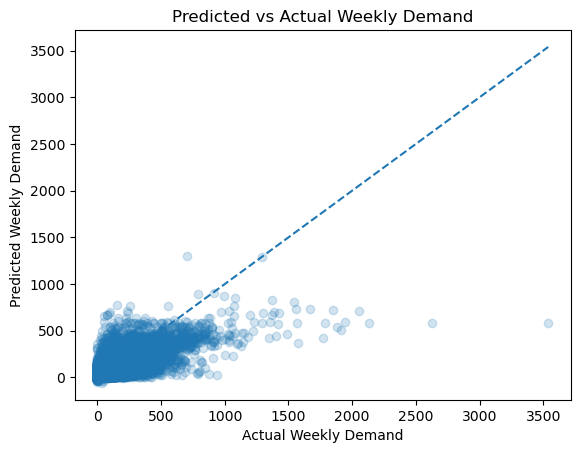

In [106]:
plt.scatter(eval_df["y_true"], eval_df["y_pred"], alpha=0.2)
plt.plot([0, eval_df["y_true"].max()],
         [0, eval_df["y_true"].max()],
         linestyle="--")
plt.xlabel("Actual Weekly Demand")
plt.ylabel("Predicted Weekly Demand")
plt.title("Predicted vs Actual Weekly Demand")
plt.show()

The predictions aligns closely with actuals across majority of observations, especially with low to moderate demand levels. The model does peform inconsistently with extreme demand values, underpredicting large promotional spikes. This aligns with the fact that their is no feature stating future promotion signals and aligns with observed error patterns.

To further evaluate the model, I compared mean absolute error (MAE), mean squared error, and R<sup>2</sup> score by each cluster to evaluate which cluster the model had a harder or easier time evaluating.

In [107]:
cluster_metrics = (
    eval_df
    .groupby("cluster")
    .apply(lambda x: pd.Series({
        "MAE": mean_absolute_error(x["y_true"], x["y_pred"]),
        "RMSE": np.sqrt(mean_squared_error(x["y_true"], x["y_pred"])),
        "Mean Actual Demand": x["y_true"].mean()
    }))
    .reset_index()
)

cluster_metrics

,cluster,MAE,RMSE,Mean Actual Demand
0,0,8.792199,23.555833,15.222258
1,1,2.036266,5.880968,2.617377
2,2,2.271230,7.005184,3.325108
3,3,1.762502,3.878036,2.410340
4,4,6.473531,15.577596,10.078571


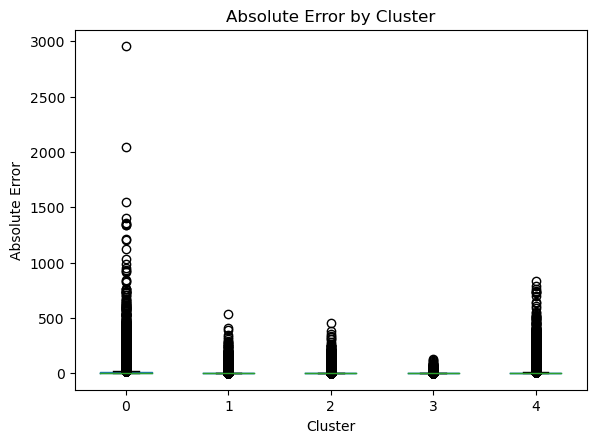

In [108]:
eval_df.boxplot(column="abs_error", by="cluster", grid=False)
plt.title("Absolute Error by Cluster")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("Absolute Error")
plt.show()

## Results & Reflections

### Overall Model Performance

The XGBoost demand forecasting model achieved an overall MAE of 4.94, RMSE of 14.87, and R² of 0.61 on the validation set. This indicates that, on average, the model predicts weekly product demand within approximately five units, while explaining over 60% of the variance in observed demand.

### Cluster-Level Performance Analysis

Model performance varies across product clusters, reflecting differences in demand stability, price sensitivity, and promotional behavior.

Products in more stable clusters (Clusters 2 and 3) show the lowest and most tightly distributed absolute errors. These products have consistent pricing, minimal discounting, and predictable demand patterns, allowing the model to learn and generalize easily.

In contrast, the clusters I believe to have a lot promotions (Clusters 1 and 4) have wider error distributions.

High-volume clusters (Clusters 0 and 4) show larger absolute errors perhaps due to their inventory sizes; however, when normalized relative to average demand, their performance remains comparable to lower-volume clusters.

When futher analyzing absolute error distributions by cluster, there are consistent patterns rather than random noise. Stable products show concentrated error distributions near zero, while volatile, promotion-sensitive products show occasional large deviations. These results align closely with the behavioral differences identified during clustering, reiterating that the model captures meaningful demand dynamics.

## Future Improvements

While creating this project, I did run into some limitations. First, the model does not explicit have a promotions column, such as planned discount depth, promotion timing, or marketing intensity. As a result, spikes driven by promotions are difficult to predict, particularly for highly promotion-sensitive clusters. 

Second, the model relies primarily on historical demand and price-based features, and does not account for external factors such as holidays or seasonality indicators. Adding seasonality features, such as holiday indicators or yearly cyclical patterns, could further enhance generalization.

Furthermore, all products are modeled using a single model. While this approach captures broad demand patterns efficiently, it could underperform for products with special behaviors, such as premium or discounted items. Additionally, new products may be diffcult to predict due to limited historical information.